# Pycaret을 이용한 베이스라인 모델 (+ 제공된 외부 데이터 활용)

In [ ]:
!pip install autogluon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.0/224.0 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.7/285.7 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.3/372.3 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 67.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.4/90.4 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 9.8 MB

# [0] 모듈 로드

- 서드파트 모듈 설치

In [ ]:
# !pip install -q pycaret
# !pip install --upgrade -q xgboost
# !pip install -q catboost
! pip install holidays

- 라이브러리 로드

In [ ]:
import pandas as pd
import numpy as np
import holidays


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

import warnings

warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# [1] 데이터 로드

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Dacon/23_대구교통사고피해예측AI경진대회/data/train.csv', encoding = 'utf-8')
test = pd.read_csv('/content/drive/MyDrive/Dacon/23_대구교통사고피해예측AI경진대회/data/test.csv', encoding = 'utf-8')
sub = pd.read_csv('/content/drive/MyDrive/Dacon/23_대구교통사고피해예측AI경진대회/data/sample_submission.csv', encoding = 'utf-8')
countrywide = pd.read_csv('/content/drive/MyDrive/Dacon/23_대구교통사고피해예측AI경진대회/data/countrywide_accident.csv', encoding = 'utf-8')
cctv = pd.read_csv('/content/drive/MyDrive/Dacon/23_대구교통사고피해예측AI경진대회/data/대구 CCTV 정보.csv', encoding = 'cp949')
park = pd.read_csv('/content/drive/MyDrive/Dacon/23_대구교통사고피해예측AI경진대회/data/대구 주차장 정보.csv', encoding = 'cp949')
child = pd.read_csv('/content/drive/MyDrive/Dacon/23_대구교통사고피해예측AI경진대회/data/대구 어린이 보호 구역 정보.csv', encoding = 'cp949')
security = pd.read_csv('/content/drive/MyDrive/Dacon/23_대구교통사고피해예측AI경진대회/data/대구 보안등 정보.csv', encoding = 'cp949')

In [ ]:
train.columns

Index(['ID', '사고일시', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형',
       '사고유형 - 세부분류', '법규위반', '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도',
       '피해운전자 차종', '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수',
       '경상자수', '부상자수', 'ECLO'],
      dtype='object')

In [ ]:
train.head()

ID           사고일시   요일 기상상태            시군구      도로형태 노면상태  \
0  ACCIDENT_00000  2019-01-01 00  화요일   맑음   대구광역시 중구 대신동  단일로 - 기타   건조   
1  ACCIDENT_00001  2019-01-01 00  화요일   흐림  대구광역시 달서구 감삼동  단일로 - 기타   건조   
2  ACCIDENT_00002  2019-01-01 01  화요일   맑음  대구광역시 수성구 두산동  단일로 - 기타   건조   
3  ACCIDENT_00003  2019-01-01 02  화요일   맑음   대구광역시 북구 복현동  단일로 - 기타   건조   
4  ACCIDENT_00004  2019-01-01 04  화요일   맑음   대구광역시 동구 신암동  단일로 - 기타   건조   

   사고유형 사고유형 - 세부분류     법규위반  ... 가해운전자 상해정도 피해운전자 차종 피해운전자 성별 피해운전자 연령  \
0  차대사람  길가장자리구역통행중  안전운전불이행  ...       상해없음      보행자        여      70세   
1  차대사람       보도통행중       기타  ...       상해없음      보행자        남      61세   
2  차대사람       차도통행중  안전운전불이행  ...       상해없음      보행자        남      38세   
3   차대차          추돌  안전운전불이행  ...       상해없음       승용        남      36세   
4   차대차          추돌  안전운전불이행  ...       상해없음       승용        남      52세   

  피해운전자 상해정도 사망자수 중상자수 경상자수  부상자수  ECLO  
0         중상    0    1    0     0     5  
1         경상    0    0    1     0     3  
2         경상    0    0    1     0     3  
3         중상    0    1    0     0     5  
4         경상    0    0    1     0     3  

[5 rows x 23 columns]

In [ ]:
test.head()

ID           사고일시   요일 기상상태              시군구        도로형태 노면상태  \
0  ACCIDENT_39609  2022-01-01 01  토요일   맑음     대구광역시 수성구 상동  교차로 - 교차로안   건조   
1  ACCIDENT_39610  2022-01-01 01  토요일   맑음    대구광역시 수성구 지산동    단일로 - 기타   건조   
2  ACCIDENT_39611  2022-01-01 04  토요일   맑음  대구광역시 수성구 수성동2가  교차로 - 교차로안   건조   
3  ACCIDENT_39612  2022-01-01 04  토요일   맑음    대구광역시 수성구 신매동    단일로 - 기타   건조   
4  ACCIDENT_39613  2022-01-01 06  토요일   맑음    대구광역시 달서구 감삼동  교차로 - 교차로안   건조   

   사고유형  
0  차대사람  
1  차대사람  
2   차대차  
3   차대차  
4   차대차

# [2] 피쳐 엔지니어링

In [ ]:
list(test.columns)

['ID', '사고일시', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형']

In [ ]:
data = train[list(test.columns)]
data_y = train['ECLO']

## 2-1 피쳐 세분화

- 시군구 세분화

In [ ]:
split_sgg = data['시군구'].str.split(' ', expand=True)
data['구'] = split_sgg[1]
data['동'] = split_sgg[2]
data.drop(['시군구'], inplace = True, axis = 1)

In [ ]:
split_sgg = test['시군구'].str.split(' ', expand=True)
test['구'] = split_sgg[1]
test['동'] = split_sgg[2]
test.drop(['시군구'], inplace = True, axis = 1)

In [ ]:
data.head(2)

ID           사고일시   요일 기상상태      도로형태 노면상태  사고유형    구    동
0  ACCIDENT_00000  2019-01-01 00  화요일   맑음  단일로 - 기타   건조  차대사람   중구  대신동
1  ACCIDENT_00001  2019-01-01 00  화요일   흐림  단일로 - 기타   건조  차대사람  달서구  감삼동

- 사고일시세분화

In [ ]:
split_time = data['사고일시'].str.split('-', expand=True)
tmp_time = split_time[2].str.split(' ', expand = True)
data['연'] = split_time[0].astype(int)
data['월'] = split_time[1].astype(int)
data['일'] = tmp_time[0].astype(int)
data['시간'] = tmp_time[1].astype(int)

#data.drop(['사고일시'], inplace = True, axis = 1)

In [ ]:
split_time = test['사고일시'].str.split('-', expand=True)
tmp_time = split_time[2].str.split(' ', expand = True)
test['연'] = split_time[0].astype(int)
test['월'] = split_time[1].astype(int)
test['일'] = tmp_time[0].astype(int)
test['시간'] = tmp_time[1].astype(int)

#test.drop(['사고일시'], inplace = True, axis = 1)

In [ ]:
data.head(2)

ID           사고일시   요일 기상상태      도로형태 노면상태  사고유형    구    동  \
0  ACCIDENT_00000  2019-01-01 00  화요일   맑음  단일로 - 기타   건조  차대사람   중구  대신동   
1  ACCIDENT_00001  2019-01-01 00  화요일   흐림  단일로 - 기타   건조  차대사람  달서구  감삼동   

      연  월  일  시간  
0  2019  1  1   0  
1  2019  1  1   0

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      39609 non-null  object
 1   사고일시    39609 non-null  object
 2   요일      39609 non-null  object
 3   기상상태    39609 non-null  object
 4   도로형태    39609 non-null  object
 5   노면상태    39609 non-null  object
 6   사고유형    39609 non-null  object
 7   구       39609 non-null  object
 8   동       39609 non-null  object
 9   연       39609 non-null  int64 
 10  월       39609 non-null  int64 
 11  일       39609 non-null  int64 
 12  시간      39609 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 3.9+ MB


- 계절 추가

In [ ]:
data['일시'] = pd.to_datetime(data['사고일시'].str[0:10])
test['일시'] = pd.to_datetime(test['사고일시'].str[0:10])

In [ ]:
def to_season( x ):
    if x in [12, 1, 2]:
        return 0 # 겨울
    elif x in [3, 4, 5]:
        return 1 # 봄
    elif x in [6, 7, 8]:
        return 2 # 여름
    else:
        return 3 # 가을
    pass

In [ ]:
data['season'] = data['월'].apply(lambda x : to_season(x))
test['season'] = test['월'].apply(lambda x : to_season(x))

- 분기 추가

In [ ]:
def to_quarter( x ):
    if x in [1,2,3]:
        return 0 # 1분기
    elif x in [4,5,6]:
        return 1 # 2분기
    elif x in [7, 8, 9]:
        return 2 # 3분기
    else:
        return 3 # 4분기
    pass


In [ ]:
data['분기'] = data['월'].apply(lambda x : to_quarter(x))
test['분기'] = test['월'].apply(lambda x : to_quarter(x))

- 휴일 추가

In [ ]:
# 한국 휴일 객체 생성
kr_holidays = holidays.KR()

# generate holiday table
holiday_df = pd.DataFrame(columns=['ds','holiday'])
holiday_df['ds'] = sorted(data['일시'])
holiday_df['holiday'] = holiday_df.ds.apply(lambda x: 1 if x in kr_holidays else 0)
data['holiday'] = holiday_df['holiday']

In [ ]:
holiday_df = pd.DataFrame(columns=['ds','holiday'])
holiday_df['ds'] = sorted(test['일시'])
holiday_df['holiday'] = holiday_df.ds.apply(lambda x: 1 if x in kr_holidays else 0)
test['holiday'] = holiday_df['holiday']

In [ ]:
data.head(2)

ID           사고일시   요일 기상상태      도로형태 노면상태  사고유형    구    동  \
0  ACCIDENT_00000  2019-01-01 00  화요일   맑음  단일로 - 기타   건조  차대사람   중구  대신동   
1  ACCIDENT_00001  2019-01-01 00  화요일   흐림  단일로 - 기타   건조  차대사람  달서구  감삼동   

      연  월  일  시간         일시  season  분기  holiday  
0  2019  1  1   0 2019-01-01       0   0        1  
1  2019  1  1   0 2019-01-01       0   0        1

In [ ]:
test.head(2)

ID           사고일시   요일 기상상태        도로형태 노면상태  사고유형    구    동  \
0  ACCIDENT_39609  2022-01-01 01  토요일   맑음  교차로 - 교차로안   건조  차대사람  수성구   상동   
1  ACCIDENT_39610  2022-01-01 01  토요일   맑음    단일로 - 기타   건조  차대사람  수성구  지산동   

      연  월  일  시간         일시  season  분기  holiday  
0  2022  1  1   1 2022-01-01       0   0        1  
1  2022  1  1   1 2022-01-01       0   0        1

# 2-2. 외부데이터 병합

- 전국 데이터

In [ ]:
countrywide.head(2)
# 전국 데이터, 일별, 요일별, 월별, 계절별, 요일별 다른 특징으로 접근해볼 수 있겠다.

ID           사고일시   요일 기상상태            시군구  \
0  COUNTRYWIDE_ACCIDENT_000000  2019-01-01 00  화요일   맑음  서울특별시 강서구 방화동   
1  COUNTRYWIDE_ACCIDENT_000001  2019-01-01 00  화요일   맑음    경기도 포천시 소흘읍   

             도로형태 노면상태  사고유형 사고유형 - 세부분류       법규위반  ... 가해운전자 상해정도 피해운전자 차종  \
0  교차로 - 교차로횡단보도내   건조  차대사람         횡단중  보행자보호의무위반  ...       상해없음      보행자   
1      교차로 - 교차로안   건조   차대차          기타  직진우회전진행방해  ...       상해없음       이륜   

  피해운전자 성별 피해운전자 연령 피해운전자 상해정도 사망자수 중상자수 경상자수  부상자수  ECLO  
0        남      40세         경상    0    0    1     0     3  
1        남      20세         경상    0    0    1     0     3  

[2 rows x 23 columns]

### CCTV 데이터

In [ ]:
cctv.head(2)

무인교통단속카메라관리번호    시도명 시군구명 도로종류 도로노선번호 도로노선명  도로노선방향          소재지도로명주소  \
0          주차12  대구광역시   남구   시도    NaN   대명로       3  대구광역시 남구 대명로 162   
1          주차13  대구광역시   남구   시도    NaN   봉덕로       3  대구광역시 남구 봉덕로 135   

               소재지지번주소         위도          경도           설치장소  단속구분  제한속도  \
0  대구광역시 남구 대명동 903-13  35.838857  128.575418  안지랑네거리1 버스정류장     4     0   
1   대구광역시 남구 봉덕동 853-8  35.844653  128.604619         효성백년가약     4     0   

   단속구간위치구분  과속단속구간길이  보호구역구분    설치연도  
0       NaN       NaN    99.0  2010.0  
1       NaN       NaN    99.0  2013.0

In [ ]:
a = list(data['동'].unique())

In [ ]:
b = list(cctv['소재지지번주소'].str.split(' ', expand=True)[2].unique())

In [ ]:
len([value for value in a if value not in b]) # 50개의 다른 동이 존재한다.

50

In [ ]:
cctv['동'] = cctv['소재지지번주소'].str.split(' ', expand=True)[2]

In [ ]:
cctv_gu = cctv[['시군구명','위도','경도','제한속도']]
cctv_dong = cctv[['동','위도','경도','제한속도']]

- 구단위 그룹화

In [ ]:
cctv_gu_tmp = cctv_gu.groupby(['시군구명']).agg({'위도' : 'std', '경도' : 'std', '제한속도' : 'mean'}).reset_index().rename(columns = {'위도' : 'cctv_위도_std_gu', '경도' : 'cctv_경도_std_gu', '제한속도' : 'cctv_제한속도_평균_gu'})
cctv_gu_tmp1 = cctv_gu.groupby(['시군구명']).agg({'위도' : 'count'}).reset_index().rename(columns = {'위도' : 'cctv_count_gu'})
cctv_gu_tmp['cctv_count_gu'] = cctv_gu_tmp1['cctv_count_gu']

- 동단위 그룹화

In [ ]:
cctv_dong_tmp = cctv_dong.groupby(['동']).agg({'위도' : 'std', '경도' : 'std', '제한속도' : 'mean'}).reset_index().rename(columns = {'위도' : 'cctv_위도_std_dong', '경도' : 'cctv_경도_std_dong', '제한속도' : 'cctv_제한속도_평균_dong'})
cctv_dong_tmp1 = cctv_dong.groupby(['동']).agg({'위도' : 'count'}).reset_index().rename(columns = {'위도' : 'cctv_count_dong'})
cctv_dong_tmp['cctv_count_dong'] = cctv_dong_tmp1['cctv_count_dong']

In [ ]:
data = data.merge(cctv_dong_tmp, how = 'left', on = '동').merge(cctv_gu_tmp, how = 'left', left_on = '구', right_on = '시군구명')
test = test.merge(cctv_dong_tmp, how = 'left', on = '동').merge(cctv_gu_tmp, how = 'left', left_on = '구', right_on = '시군구명')

In [ ]:
data = data.where(pd.notnull(data), data.min(), axis='columns')
test = test.where(pd.notnull(test), test.min(), axis='columns')

### 주차장 데이터
    * 동별
        - 주차구획수 합, 위도 std, 경도 std
    * 구별
        - 주차구획수 합, 위도 std, 경도 std

In [ ]:
park.columns, park.shape

(Index(['주차장관리번호', '주차장명', '주차장구분', '주차장유형', '소재지도로명주소', '소재지지번주소', '주차구획수',
        '급지구분', '부제시행구분', '운영요일', '평일운영시작시각', '평일운영종료시각', '토요일운영시작시각',
        '토요일운영종료시각', '공휴일운영시작시각', '공휴일운영종료시각', '요금정보', '주차기본시간', '주차기본요금',
        '추가단위시간', '추가단위요금', '1일주차권요금적용시간', '1일주차권요금', '월정기권요금', '결제방법', '특기사항',
        '위도', '경도', '데이터기준일자'],
       dtype='object'),
 (871, 29))

In [ ]:
park['시군구명'] = park['소재지지번주소'].str.split(' ', expand=True)[1]
park['동'] = park['소재지지번주소'].str.split(' ', expand=True)[2]

In [ ]:
park_gu = park[['시군구명','위도','경도','주차구획수']]
park_dong = park[['동','위도','경도','주차구획수']]

- 구단위 그룹화

In [ ]:
park_gu_tmp = park_gu.groupby(['시군구명']).agg({'위도' : 'std', '경도' : 'std', '주차구획수' : 'sum'}).reset_index().rename(columns = {'위도' : 'park_위도_std_gu', '경도' : 'park_경도_std_gu', '주차구획수' : '주차구획수_gu'})

- 동단위 그룹화

In [ ]:
park_dong_tmp = park_dong.groupby(['동']).agg({'위도' : 'std', '경도' : 'std', '주차구획수' : 'sum'}).reset_index().rename(columns = {'위도' : 'park_위도_std_dong', '경도' : 'park_경도_std_dong','주차구획수' : '주차구획수_dong'})

- 원본과 결합

In [ ]:
data = data.merge(park_dong_tmp, how = 'left', on = '동').merge(park_gu_tmp, how = 'left', left_on = '구', right_on = '시군구명')
test = test.merge(park_dong_tmp, how = 'left', on = '동').merge(park_gu_tmp, how = 'left', left_on = '구', right_on = '시군구명')

In [ ]:
data = data.where(pd.notnull(data), data.min(), axis='columns')
test = test.where(pd.notnull(test), test.min(), axis='columns')

### 어린이보호구역 데이터

In [ ]:
child.head(2)

시설종류   대상시설명               소재지도로명주소            소재지지번주소         위도  \
0  초등학교  남도초등학교  대구광역시 남구 현충동길 74(대명동)  대구광역시 남구 대명동 1709  35.845027   
1  초등학교  영선초등학교    대구광역시 남구 영선길96(이천동)   대구광역시 남구 이천동 477  35.852901   

           경도  관리기관명 관할경찰서명 CCTV설치여부  CCTV설치대수 보호구역도로폭     데이터기준일자  
0  128.581402  대구광역시  남부경찰서        Y       7.0     6~8  2020-03-23  
1  128.596014  대구광역시  남부경찰서        Y       8.0    6~10  2020-03-23

In [ ]:
child.shape

(640, 12)

In [ ]:
child['시군구명'] = child['소재지지번주소'].str.split(' ', expand=True)[1]
child['동'] = child['소재지지번주소'].str.split(' ', expand=True)[2]

In [ ]:
child_gu = child[['시군구명','위도','경도','CCTV설치대수','대상시설명']]
child_dong = child[['동','위도','경도','CCTV설치대수','대상시설명']]

- 구단위 그룹화

In [ ]:
child_gu_tmp = child_gu.groupby(['시군구명']).agg({'위도' : 'std', '경도' : 'std', 'CCTV설치대수' : 'sum', '대상시설명':'count'}).reset_index().rename(columns = {'위도' : 'child_위도_std_gu', '경도' : 'child_경도_std_gu', 'CCTV설치대수' : 'CCTV설치대수_gu', '대상시설명' : 'child_count_gu'})

- 동단위 그룹화

In [ ]:
child_dong_tmp = child_dong.groupby(['동']).agg({'위도' : 'std', '경도' : 'std', 'CCTV설치대수' : 'sum', '대상시설명':'count'}).reset_index().rename(columns = {'위도' : 'child_위도_std_dong', '경도' : 'child_경도_std_dong', 'CCTV설치대수' : 'CCTV설치대수_dong', '대상시설명' : 'child_count_dong'})

- 원본과 결합

In [ ]:
data = data.merge(child_dong_tmp, how = 'left', on = '동').merge(child_gu_tmp, how = 'left', left_on = '구', right_on = '시군구명')
test = test.merge(child_dong_tmp, how = 'left', on = '동').merge(child_gu_tmp, how = 'left', left_on = '구', right_on = '시군구명')

In [ ]:
data = data.where(pd.notnull(data), data.min(), axis='columns')
test = test.where(pd.notnull(test), test.min(), axis='columns')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39609 entries, 0 to 39608
Data columns (total 42 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ID                 39609 non-null  object        
 1   사고일시               39609 non-null  object        
 2   요일                 39609 non-null  object        
 3   기상상태               39609 non-null  object        
 4   도로형태               39609 non-null  object        
 5   노면상태               39609 non-null  object        
 6   사고유형               39609 non-null  object        
 7   구                  39609 non-null  object        
 8   동                  39609 non-null  object        
 9   연                  39609 non-null  int64         
 10  월                  39609 non-null  int64         
 11  일                  39609 non-null  int64         
 12  시간                 39609 non-null  int64         
 13  일시                 39609 non-null  datetime64[ns]
 14  season

- 보안등데이터

In [ ]:
security.shape

(71913, 8)

In [ ]:
security.head(2)

보안등위치명  설치개수              소재지도로명주소               소재지지번주소         위도  \
0  대명1동1     1      대구광역시 남구 현충로 155   대구광역시 남구 대명동 1722-4  35.846703   
1  대명1동2     1  대구광역시 남구 현충로31길 10-1  대구광역시 남구 대명동 1723-11  35.846863   

           경도    설치연도 설치형태  
0  128.579803  2016.0  한전주  
1  128.579406  2016.0  한전주

In [ ]:
security['시군구명'] = security['소재지지번주소'].str.split(' ', expand=True)[1]
security['동'] = security['소재지지번주소'].str.split(' ', expand=True)[2]

In [ ]:
security_gu = security[['시군구명','위도','경도','설치개수','보안등위치명']]
security_dong = security[['동','위도','경도','설치개수','보안등위치명']]

- 구단위 그룹화

In [ ]:
security_gu_tmp = security_gu.groupby(['시군구명']).agg({'위도' : 'std', '경도' : 'std', '설치개수' : 'sum'}).reset_index().rename(columns = {'위도' : 'security_위도_std_gu', '경도' : 'security_경도_std_gu', '설치개수' : 'security설치대수_gu', '보안등위치명' : 'security_count_gu'})

- 동단위 그룹화

In [ ]:
security_dong_tmp = security_dong.groupby(['동']).agg({'위도' : 'std', '경도' : 'std', '설치개수' : 'sum'}).reset_index().rename(columns = {'위도' : 'security_위도_std_dong', '경도' : 'security_경도_std_dong', '설치개수' : 'security설치대수_dong'})

In [ ]:
security_dong_tmp

동  security_위도_std_dong  security_경도_std_dong  security설치대수_dong
0       988-130                   NaN                   NaN                  1
1           가창면                   NaN                   NaN               1123
2           각산동              0.002685              0.004169                139
3           갈산동              0.003868              0.004576                349
4    갈산동358-171                   NaN                   NaN                  1
..          ...                   ...                   ...                ...
974         화원읍                   NaN                   NaN                940
975         화전동              0.000367              0.000277                 22
976        황금1동                   NaN                   NaN                153
977        황금2동                   NaN                   NaN                590
978         효목동              0.003603              0.004426               1164

[979 rows x 4 columns]

- 원본과 결합

In [ ]:
data = data.merge(security_dong_tmp, how = 'left', on = '동').merge(security_gu_tmp, how = 'left', left_on = '구', right_on = '시군구명')
test = test.merge(security_dong_tmp, how = 'left', on = '동').merge(security_gu_tmp, how = 'left', left_on = '구', right_on = '시군구명')

In [ ]:
data.drop(['시군구명_x','시군구명_y'], axis = 1, inplace = True)
test.drop(['시군구명_x','시군구명_y'], axis = 1, inplace = True)

In [ ]:
data = data.where(pd.notnull(data), data.mean(), axis='columns')
test = test.where(pd.notnull(test), test.mean(), axis='columns')

## 데이터 확인

In [ ]:
data.columns

Index(['ID', '사고일시', '요일', '기상상태', '도로형태', '노면상태', '사고유형', '구', '동', '연', '월',
       '일', '시간', '일시', 'season', '분기', 'holiday', 'cctv_위도_std_dong',
       'cctv_경도_std_dong', 'cctv_제한속도_평균_dong', 'cctv_count_dong',
       'cctv_위도_std_gu', 'cctv_경도_std_gu', 'cctv_제한속도_평균_gu', 'cctv_count_gu',
       'park_위도_std_dong', 'park_경도_std_dong', '주차구획수_dong', 'park_위도_std_gu',
       'park_경도_std_gu', '주차구획수_gu', 'child_위도_std_dong', 'child_경도_std_dong',
       'CCTV설치대수_dong', 'child_count_dong', 'child_위도_std_gu',
       'child_경도_std_gu', 'CCTV설치대수_gu', 'child_count_gu',
       'security_위도_std_dong', 'security_경도_std_dong', 'security설치대수_dong',
       'security_위도_std_gu', 'security_경도_std_gu', 'security설치대수_gu'],
      dtype='object')

In [ ]:
test

ID           사고일시   요일 기상상태         도로형태 노면상태  사고유형    구  \
0      ACCIDENT_39609  2022-01-01 01  토요일   맑음   교차로 - 교차로안   건조  차대사람  수성구   
1      ACCIDENT_39610  2022-01-01 01  토요일   맑음     단일로 - 기타   건조  차대사람  수성구   
2      ACCIDENT_39611  2022-01-01 04  토요일   맑음   교차로 - 교차로안   건조   차대차  수성구   
3      ACCIDENT_39612  2022-01-01 04  토요일   맑음     단일로 - 기타   건조   차대차  수성구   
4      ACCIDENT_39613  2022-01-01 06  토요일   맑음   교차로 - 교차로안   건조   차대차  달서구   
...               ...            ...  ...  ...          ...  ...   ...  ...   
10958  ACCIDENT_50567  2022-12-31 18  토요일   맑음     단일로 - 터널   건조   차대차   남구   
10959  ACCIDENT_50568  2022-12-31 18  토요일   맑음     단일로 - 기타   건조   차대차  수성구   
10960  ACCIDENT_50569  2022-12-31 20  토요일   맑음     단일로 - 기타   건조   차대차  수성구   
10961  ACCIDENT_50570  2022-12-31 20  토요일   맑음  교차로 - 교차로부근   건조   차대차  수성구   
10962  ACCIDENT_50571  2022-12-31 21  토요일   맑음  교차로 - 교차로부근   건조   차대차   동구   

           동     연  ...  child_위도_std_gu  child_경도_std_gu  CCTV설치대수_gu  \
0         상동  2022  ...         0.015045         0.035686            0   
1        지산동  2022  ...         0.015045         0.035686            0   
2      수성동2가  2022  ...         0.015045         0.035686            0   
3        신매동  2022  ...         0.015045         0.035686            0   
4        감삼동  2022  ...         0.004374         0.009301            0   
...      ...   ...  ...              ...              ...          ...   
10958    대명동  2022  ...         0.008479         0.013097          162   
10959    시지동  2022  ...         0.015045         0.035686            0   
10960    연호동  2022  ...         0.015045         0.035686            0   
10961    범물동  2022  ...         0.015045         0.035686            0   
10962    효목동  2022  ...         0.004374         0.009301            0   

      child_count_gu  security_위도_std_dong  security_경도_std_dong  \
0                118              0.004207              0.005234   
1                118              0.004207              0.005234   
2                118              0.004207              0.005234   
3                118              0.004207              0.005234   
4                 21              0.003525              0.003298   
...              ...                   ...                   ...   
10958             40              0.007467              0.009185   
10959            118              0.004207              0.005234   
10960            118              0.004207              0.005234   
10961            118              0.004207              0.005234   
10962             21              0.003603              0.004426   

       security설치대수_dong security_위도_std_gu security_경도_std_gu security설치대수_gu  
0             700.000000           0.019177           0.023295           11911  
1             850.816225           0.019177           0.023295           11911  
2             850.816225           0.019177           0.023295           11911  
3             850.816225           0.019177           0.023295           11911  
4             932.000000           0.016638           0.021791           10083  
...                  ...                ...                ...             ...  
10958        5377.000000           0.007213           0.012932            7357  
10959         850.816225           0.019177           0.023295           11911  
10960         850.816225           0.019177           0.023295           11911  
10961         850.816225           0.019177           0.023295           11911  
10962        1164.000000           0.032172           0.035014           11926  

[10963 rows x 45 columns]

# [3] 인코딩

## 2-1. 라벨 인코딩

In [ ]:
qual_col = ['요일', '기상상태', '도로형태', '노면상태', '사고유형', '구', '동']

for i in qual_col:
    le = LabelEncoder()
    data[i]=le.fit_transform(data[i])
    test[i]=le.transform(test[i])

print('Done.')

Done.


In [ ]:
data.drop(['ID'], axis = 1, inplace = True)
test.drop(['ID'], axis = 1, inplace = True)

In [ ]:
data.columns == test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [ ]:
data.drop(['사고일시','일시'], axis = 1, inplace = True)
test.drop(['사고일시','일시'], axis = 1, inplace = True)

# 스케일링

In [ ]:
# 스케일링 제외 (Label Encoder)
exclude_columns = ['요일', '기상상태', '도로형태', '노면상태', '사고유형', '구', '동', '연','월','일','시간','season','분기']

# 스케일링할 데이터프레임 선택
data_to_scale = data.drop(columns=exclude_columns)

# MinMaxScaler 초기화 및 학습 데이터로 fit
scaler = MinMaxScaler()
scaler.fit(data_to_scale)

# 스케일링된 데이터프레임 생성
scaled_data = pd.DataFrame(scaler.transform(data_to_scale), columns=data_to_scale.columns)

# 스케일링된 데이터프레임을 원래의 형태로 변환
scaled_data[exclude_columns] = data[exclude_columns]

# Test 데이터프레임에 스케일링 적용
scaled_test = pd.DataFrame(scaler.transform(test.drop(columns=exclude_columns)), columns=data_to_scale.columns)
scaled_test[exclude_columns] = test[exclude_columns]

In [ ]:
scaled_data

holiday  cctv_위도_std_dong  cctv_경도_std_dong  cctv_제한속도_평균_dong  \
0          1.0          0.070928          0.042204           0.080000   
1          1.0          0.132602          0.107823           0.175000   
2          1.0          0.155632          0.061045           0.550000   
3          1.0          0.149004          0.067639           0.380000   
4          1.0          0.183063          0.134565           0.400000   
...        ...               ...               ...                ...   
39604      0.0          0.000000          0.000000           0.400000   
39605      0.0          0.201416          0.208482           0.266667   
39606      0.0          0.152648          0.072433           0.168182   
39607      0.0          0.000000          0.000000           0.600000   
39608      0.0          0.309399          0.128634           0.478571   

       cctv_count_dong  cctv_위도_std_gu  cctv_경도_std_gu  cctv_제한속도_평균_gu  \
0             0.065574        0.000000        0.000000         0.000000   
1             0.180328        0.205787        0.251624         0.160913   
2             0.049180        0.198246        0.488647         0.876405   
3             0.147541        0.259812        0.424605         0.747126   
4             0.180328        0.475415        0.630201         1.000000   
...                ...             ...             ...              ...   
39604         0.000000        0.198246        0.488647         0.876405   
39605         0.475410        0.205787        0.251624         0.160913   
39606         0.344262        0.205787        0.251624         0.160913   
39607         0.000000        0.205787        0.251624         0.160913   
39608         0.213115        0.059832        0.065880         0.783077   

       cctv_count_gu  park_위도_std_dong  ...  노면상태  사고유형  구    동     연   월   일  \
0           0.081081          0.050523  ...     0     0  7   40  2019   1   1   
1           1.000000          0.049152  ...     0     0  1    4  2019   1   1   
2           0.211712          0.000000  ...     0     0  6   66  2019   1   1   
3           0.315315          0.033996  ...     0     1  4   79  2019   1   1   
4           0.166667          0.000000  ...     0     1  3  129  2019   1   1   
...              ...               ...  ...   ...   ... ..  ...   ...  ..  ..   
39604       0.211712          0.000000  ...     0     1  6  118  2021  12  31   
39605       1.000000          0.063670  ...     0     1  1  103  2021  12  31   
39606       1.000000          0.000000  ...     0     1  1  144  2021  12  31   
39607       1.000000          0.000000  ...     0     1  1  158  2021  12  31   
39608       0.000000          0.000000  ...     0     1  5   89  2021  12  31   

       시간  season  분기  
0       0       0   0  
1       0       0   0  
2       1       0   0  
3       2       0   0  
4       4       0   0  
...    ..     ...  ..  
39604  19       0   3  
39605  19       0   3  
39606  21       0   3  
39607  22       0   3  
39608  23       0   3  

[39609 rows x 42 columns]

In [ ]:
scaled_test

holiday  cctv_위도_std_dong  cctv_경도_std_dong  cctv_제한속도_평균_dong  \
0          1.0          0.214762          0.086990           0.525000   
1          1.0          0.142525          0.139328           0.471429   
2          1.0          0.000000          0.000000           0.400000   
3          1.0          0.118887          0.104830           0.427273   
4          1.0          0.132602          0.107823           0.175000   
...        ...               ...               ...                ...   
10958      0.0          0.325277          0.245113           0.204839   
10959      0.0          0.111991          0.109783           0.525000   
10960      0.0          0.000000          0.000000           0.000000   
10961      0.0          0.082608          0.077744           0.442857   
10962      0.0          0.163156          0.046209           0.425000   

       cctv_count_dong  cctv_위도_std_gu  cctv_경도_std_gu  cctv_제한속도_평균_gu  \
0             0.049180        0.198246        0.488647         0.876405   
1             0.098361        0.198246        0.488647         0.876405   
2             0.000000        0.198246        0.488647         0.876405   
3             0.163934        0.198246        0.488647         0.876405   
4             0.180328        0.205787        0.251624         0.160913   
...                ...             ...             ...              ...   
10958         1.000000        0.048759        0.121621         0.029978   
10959         0.049180        0.198246        0.488647         0.876405   
10960         0.000000        0.198246        0.488647         0.876405   
10961         0.098361        0.198246        0.488647         0.876405   
10962         0.049180        0.475415        0.630201         1.000000   

       cctv_count_gu  park_위도_std_dong  ...  노면상태  사고유형  구    동     연   월   일  \
0           0.211712          0.000000  ...     0     0  6   99  2022   1   1   
1           0.211712          0.000900  ...     0     0  6  168  2022   1   1   
2           0.211712          0.000000  ...     0     1  6  117  2022   1   1   
3           0.211712          0.021068  ...     0     1  6  126  2022   1   1   
4           1.000000          0.049152  ...     0     1  1    4  2022   1   1   
...              ...               ...  ...   ...   ... ..  ...   ...  ..  ..   
10958       0.175676          0.130177  ...     0     1  0   38  2022  12  31   
10959       0.211712          0.000000  ...     0     1  6  123  2022  12  31   
10960       0.211712          0.000000  ...     0     1  6  134  2022  12  31   
10961       0.211712          0.000000  ...     0     1  6   77  2022  12  31   
10962       0.166667          0.000000  ...     0     1  3  195  2022  12  31   

       시간  season  분기  
0       1       0   0  
1       1       0   0  
2       4       0   0  
3       4       0   0  
4       6       0   0  
...    ..     ...  ..  
10958  18       0   3  
10959  18       0   3  
10960  20       0   3  
10961  20       0   3  
10962  21       0   3  

[10963 rows x 42 columns]

In [ ]:
scaled_data.columns == scaled_test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

# 모델링

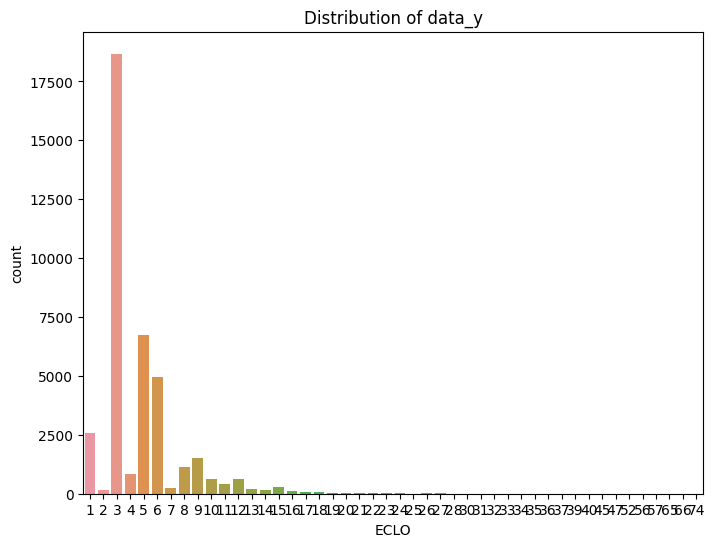

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.countplot(x= data_y)
plt.title('Distribution of data_y')
plt.show()

In [ ]:
stratify_label = np.digitize(data_y, np.linspace(0, 10, 11))

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(scaled_data, data_y,
                                                  random_state = 22,
                                                  stratify=stratify_label,
                                                  test_size = 0.3)

In [ ]:
from autogluon.tabular import TabularPredictor

# autogluon은 데이터 프레임 하나만 들어감
X = pd.concat([X_train, y_train], axis = 1)

predictor = TabularPredictor(label='ECLO', problem_type = 'regression').fit(train_data=X, presets = 'best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20231124_034335/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231124_034335/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
Disk Space Avail:   206.74 GB / 242.49 GB (85.3%)
Train Data Rows:    27726
Train Data Columns: 42
Label Column: ECLO
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11244.84 MB
	Train Data (Original)  Memory Usage: 9.32 MB (0.1% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting A

In [ ]:
results = predictor.fit_summary()
predictor.get_model_best()

*** Summary of fit() ***
Estimated performance of each model:
                     model  score_val  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -3.186880      27.041177  2640.679347                0.001785           1.299246            3       True         22
1          CatBoost_BAG_L2  -3.194045      18.349209  1316.835897                0.115907          47.493543            2       True         16
2      WeightedEnsemble_L2  -3.195186       4.401237   649.730975                0.003815           1.205786            2       True         12
3        LightGBMXT_BAG_L2  -3.196556      18.753854  1313.429214                0.520552          44.086860            2       True         13
4          CatBoost_BAG_L1  -3.196636       0.080838    45.416127                0.080838          45.416127            1       True          6
5          LightGBM_BAG_L2  -3.198583      18.561379  1319.598700         

'WeightedEnsemble_L3'

In [ ]:
from sklearn.metrics import mean_squared_error
def rmsle(y_true, y_pred):
    # RMSE 계산
    mse = mean_squared_error(np.log1p(y_true), np.log1p(y_pred))
    # 로그 스케일에서의 RMSE 반환
    return np.sqrt(mse)

In [ ]:
pred_y = predictor.predict(X_val)

print(rmsle(y_val, pred_y))

0.45910591744817647


In [ ]:
pred_test = predictor.predict(scaled_test)
pred_test

0        4.340640
1        4.008526
2        5.496314
3        5.285506
4        5.268803
           ...   
10958    5.159343
10959    5.066270
10960    5.311515
10961    5.239764
10962    5.443076
Name: ECLO, Length: 10963, dtype: float32

In [ ]:
sub['ECLO'] = pred_test
sub

ID      ECLO
0      ACCIDENT_39609  4.340640
1      ACCIDENT_39610  4.008526
2      ACCIDENT_39611  5.496314
3      ACCIDENT_39612  5.285506
4      ACCIDENT_39613  5.268803
...               ...       ...
10958  ACCIDENT_50567  5.159343
10959  ACCIDENT_50568  5.066270
10960  ACCIDENT_50569  5.311515
10961  ACCIDENT_50570  5.239764
10962  ACCIDENT_50571  5.443076

[10963 rows x 2 columns]

In [ ]:
sub.to_csv('/content/drive/MyDrive/Dacon/23_대구교통사고피해예측AI경진대회/submissions/submission_6.csv', index = False)